# Elective Project
# Amazon Recommendation System

## Install libraries

In [82]:
# Install required libraries
!pip install scikit-surprise torch --quiet

In [83]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns

# plotting
import matplotlib.pyplot as plt

# error handling
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

print(f'NumPy version: {np.__version__}')
print(f'Pandas version: {pd.__version__}')
print('All libraries imported successfully!')

NumPy version: 1.26.4
Pandas version: 2.2.2
All libraries imported successfully!


## Load data

In [84]:
# Load the dataset
data = pd.read_csv("/Users/lukeroberts/My Drive(lukejrobertsza@gmail.com)/Colab Notebooks/mit_adsp_notebooks/7.1.elective_project/ratings_Electronics.csv")
data.columns = ['user_id', 'item_id', 'rating', 'timestamp']
print(f"Dataset loaded successfully with {data.shape[0]} rows and {data.shape[1]} columns.")

Dataset loaded successfully with 7824481 rows and 4 columns.


In [85]:
# copy data
copy_of_data = data.copy()

## Define functions

In [86]:
import pandas as pd

def function_unique_values(df: pd.DataFrame) -> dict:
    """
    Returns a dictionary with column names as keys and lists of unique values as values.
    Also prints the count of unique values per column.

    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame to analyze

    Returns:
    --------
    dict
        Dictionary with column names as keys and unique values as values
    """
    unique_values = {}
    print("Number of unique values per column:")
    for column in df.columns:
        uniques = df[column].unique()
        unique_values[column] = uniques
        print(f"{column}: {len(uniques):,} unique values")

    return unique_values

In [87]:
# Test the function to display unique values in each column
function_unique_values(data);

Number of unique values per column:
user_id: 4,201,696 unique values
item_id: 476,001 unique values
rating: 5 unique values
user_id: 4,201,696 unique values
item_id: 476,001 unique values
rating: 5 unique values
timestamp: 5,489 unique values
timestamp: 5,489 unique values


In [88]:
import pandas as pd

def function_sparsity(df: pd.DataFrame) -> float:
    """
    Calculate the sparsity of a user-item interaction matrix.

    Sparsity is defined as: 1 - (number of observed interactions / total possible interactions)

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing user-item interactions

    Returns:
    --------
    float
        Sparsity value between 0 and 1, where higher values indicate more sparsity
    """
    # Count unique users and items
    n_users = df['user_id'].nunique()
    n_items = df['item_id'].nunique()

    # Total possible interactions
    total_possible = n_users * n_items

    # Number of observed interactions
    observed = len(df)

    # Calculate sparsity
    sparsity = 1 - (observed / total_possible)

    print(f"Number of users: {n_users:,}")
    print(f"Number of items: {n_items:,}")
    print(f"Number of observed interactions: {observed:,}")
    print(f"Number of possible interactions: {total_possible:,}")
    print(f"Matrix sparsity: {sparsity:.6f} ({sparsity:.4%})")

    return sparsity

In [89]:
function_sparsity(data)

Number of users: 4,201,696
Number of items: 476,001
Number of observed interactions: 7,824,481
Number of possible interactions: 2,000,011,497,696
Matrix sparsity: 0.999996 (99.9996%)


0.9999960877819908

In [90]:
# Calculate the number of ratings per user efficiently using pandas
ratings_count = data['user_id'].value_counts()

# Display the first few entries of the ratings count for verification
print(ratings_count.head())

user_id
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
Name: count, dtype: int64


In [91]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_filtered_users = data.loc[ ~ data.user_id.isin(remove_users)]

In [92]:
df_filtered_users.groupby('user_id').count().sort_values(by='item_id', ascending=True)

,item_id,rating,timestamp
user_id,,,
A2RS66Y79Q8X0W,50,50,50
A2Y4H3PXB07WQI,50,50,50
A3VZH0PWLQ9BB1,50,50,50
A19N3S7CBSU6O7,50,50,50
A1IU4UAV9QIJAI,50,50,50
...,...,...,...
A680RUE1FDO8B,406,406,406
A6FIAB28IS79,431,431,431
A3OXHLG6DIBRW8,498,498,498


In [93]:
df_filtered_users.groupby('item_id').count().sort_values(by='user_id', ascending=True)

,user_id,rating,timestamp
item_id,,,
0594451647,1,1,1
B004AAPKTW,1,1,1
B004AAZXQM,1,1,1
B004AB02IA,1,1,1
B004AB1OS2,1,1,1
...,...,...,...
B00829TIEK,149,149,149
B007WTAJTO,164,164,164
B000N99BBC,167,167,167


In [94]:
df_filtered_users[df_filtered_users.item_id == 'B003ES5ZUU']

,user_id,item_id,rating,timestamp
3313485,AAXAKFQEAQPWC,B003ES5ZUU,3.0,1401580800
3313489,A3CW0ZLUO5X2B1,B003ES5ZUU,5.0,1322870400
3313604,ADLVFFE4VBT8,B003ES5ZUU,5.0,1292371200
3313634,A32O98PFC3OP7K,B003ES5ZUU,5.0,1361059200
3313778,A32QOZWIKQDNZX,B003ES5ZUU,5.0,1300320000
...,...,...,...,...
3323616,A1MFPAM9TTRTXN,B003ES5ZUU,5.0,1402185600
3323625,A3TCMJ6GKZJFBQ,B003ES5ZUU,3.0,1292716800
3323638,A2I2KPNJDQ9SL0,B003ES5ZUU,5.0,1365206400
3323658,A3CG93783LP0FO,B003ES5ZUU,5.0,1385942400


In [95]:
function_unique_values(df_filtered_users), function_sparsity(df_filtered_users);

Number of unique values per column:
user_id: 1,540 unique values
item_id: 48,190 unique values
rating: 5 unique values
timestamp: 4,600 unique values
Number of users: 1,540
Number of items: 48,190
Number of observed interactions: 125,871
Number of possible interactions: 74,212,600
Matrix sparsity: 0.998304 (99.8304%)


In [96]:
# Calculate the number of ratings per item efficiently using pandas
item_ratings_count = df_filtered_users['item_id'].value_counts()

# Display the first few entries of the item ratings count for verification
print(item_ratings_count.head())

# Filter items with at least 5 ratings
RATINGS_CUTOFF = 5
df_final = df_filtered_users[df_filtered_users['item_id'].map(item_ratings_count) >= RATINGS_CUTOFF]

# Display the shape of the final dataset
print(f"Filtered dataset contains {df_final.shape[0]} rows and {df_final.shape[1]} columns.")

item_id
B0088CJT4U    206
B003ES5ZUU    184
B000N99BBC    167
B007WTAJTO    164
B00829TIEK    149
Name: count, dtype: int64
Filtered dataset contains 65290 rows and 4 columns.


In [97]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_items = []

for prod, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_items.append(prod)

# Filter df_filtered_users to keep only items with enough ratings
df_final = df_filtered_users.loc[~df_filtered_users.item_id.isin(remove_items)]

In [98]:
function_sparsity(df_final);

Number of users: 1,540
Number of items: 48,190
Number of observed interactions: 125,871
Number of possible interactions: 74,212,600
Matrix sparsity: 0.998304 (99.8304%)


In [99]:
function_unique_values(df_final);

Number of unique values per column:
user_id: 1,540 unique values
item_id: 48,190 unique values
rating: 5 unique values
timestamp: 4,600 unique values


## EDA

In [100]:
# shape of the data
df_final.shape

# Display the shape and summary statistics of the filtered dataset
print(f"Filtered dataset contains {df_final.shape[0]} rows and {df_final.shape[1]} columns.")
print("\nSummary statistics:")
print(df_final.describe())

Filtered dataset contains 125871 rows and 4 columns.

Summary statistics:
              rating     timestamp
count  125871.000000  1.258710e+05
mean        4.261339  1.321979e+09
std         1.062144  7.583599e+07
min         1.000000  9.396000e+08
25%         4.000000  1.286928e+09
50%         5.000000  1.346717e+09
75%         5.000000  1.377130e+09
max         5.000000  1.406074e+09


Observations:
- there are 65,290 rows and 3 columns

In [101]:
# check data types
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 125871 entries, 93 to 7824443
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    125871 non-null  object 
 1   item_id    125871 non-null  object 
 2   rating     125871 non-null  float64
 3   timestamp  125871 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 4.8+ MB


Observations:
- user_id and item_id are strings, objects
- rating is numerical, float64
- there are no missing values, all columns uqual each other

In [102]:
# final check for missing values
df_final.isna().sum()

user_id      0
item_id      0
rating       0
timestamp    0
dtype: int64

Observations:
- explicitly calling .isna() on our df still shows there are no missing values

In [103]:
# summary statists
df_final.describe()

# Final summary statistics for the dataset
print("Final dataset summary:")
print(df_final.describe(include='all'))
print("\nData types:")
print(df_final.dtypes)
print("\nMissing values check:")
print(df_final.isna().sum())

Final dataset summary:
              user_id     item_id         rating     timestamp
count          125871      125871  125871.000000  1.258710e+05
unique           1540       48190            NaN           NaN
top     A5JLAU2ARJ0BO  B0088CJT4U            NaN           NaN
freq              520         206            NaN           NaN
mean              NaN         NaN       4.261339  1.321979e+09
std               NaN         NaN       1.062144  7.583599e+07
min               NaN         NaN       1.000000  9.396000e+08
25%               NaN         NaN       4.000000  1.286928e+09
50%               NaN         NaN       5.000000  1.346717e+09
75%               NaN         NaN       5.000000  1.377130e+09
max               NaN         NaN       5.000000  1.406074e+09

Data types:
user_id       object
item_id       object
rating       float64
timestamp      int64
dtype: object

Missing values check:
user_id      0
item_id      0
rating       0
timestamp    0
dtype: int64


Observations:
- when calling .describe() statistics are only generataed for numerical columns, 'rating' in our case
- there are 65,290 counts of data, which confirms our index value when calling . info() earlier
- the mean rating is ~ 4.2, indicating a tendency toward higher ratings in the dataset
- the minimum rating is 1.0 and the maximum is 5.0, confirming the range of the rating scale
- the standard deviation is ~ 1.3, suggesting moderate variability in user ratings
- the 25th, 50th (median), and 75th percentiles are 4.0, 5.0, and 5.0 respectively, showing that most ratings are at the higher end of the scale
- **this skew toward higher ratings may impact the recommendation model's ability to distinguish between truly preferred and less preferred items**

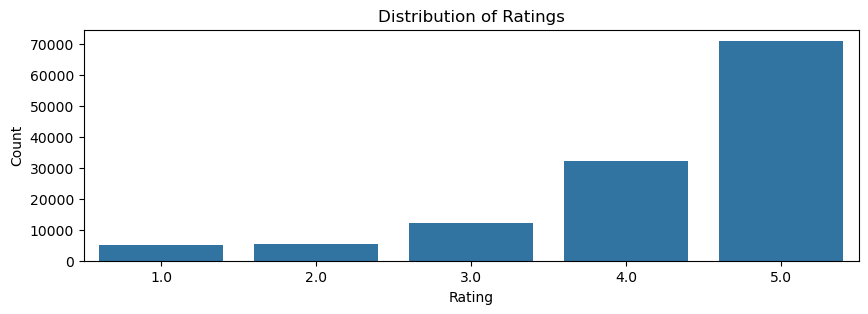

In [104]:
# plot of distribution of the data

plt.figure(figsize=(10,3))
sns.countplot(x='rating', data=df_final)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [105]:
# unique values
function_unique_values(df_final);

Number of unique values per column:
user_id: 1,540 unique values
item_id: 48,190 unique values
rating: 5 unique values
timestamp: 4,600 unique values


Observations:
- there are 1,540 unique users in dataset
- there are 5,689 unique items
- there are all 5 rating's grades used

In [106]:
# top 10 users

top_10_users = df_final.groupby('user_id')['rating'].count().sort_values(ascending=False).head(10)
print(f"top 10 users: {top_10_users}")

# percentage of top 10 users
print(f"contribution of top 10 users: {top_10_users.sum() / df_final['rating'].sum() * 100:.2%}")

# top 10 users ratio
print(f"top 10 users out of all users: {top_10_users.count() / df_final['user_id'].nunique():.2%}")

top 10 users: user_id
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
ARBKYIVNYWK3C     296
Name: rating, dtype: int64
contribution of top 10 users: 73.92%
top 10 users out of all users: 0.65%


Observations:
- the top 10 users are displayed above, with the top users rating 295 items
- the top 10 users account for 75% of all ratings
- the top 10 users are the top 0.65% of all users

# Model 1: Rank Based RS

In [107]:
# calcualte average rating for each product
average_rating_item = df_final.groupby('item_id')['rating'].mean()
average_rating_item

item_id
0594451647    5.000000
0594481813    3.000000
0970407998    2.500000
0972683275    4.750000
1400501466    3.333333
                ...   
B00LED02VY    4.000000
B00LGN7Y3G    5.000000
B00LGQ6HL8    5.000000
B00LI4ZZO8    4.500000
B00LKG1MC8    5.000000
Name: rating, Length: 48190, dtype: float64

In [108]:
# number of ratings per product (count)
count_rating_item = df_final.groupby('item_id')['rating'].count()
count_rating_item, type(count_rating_item)

(item_id
 0594451647    1
 0594481813    1
 0970407998    2
 0972683275    4
 1400501466    6
              ..
 B00LED02VY    1
 B00LGN7Y3G    1
 B00LGQ6HL8    5
 B00LI4ZZO8    2
 B00LKG1MC8    1
 Name: rating, Length: 48190, dtype: int64,
 pandas.core.series.Series)

In [109]:
metrics_rating_item = pd.DataFrame(
    {
    'average_rating': average_rating_item,
    'count_ratings': count_rating_item
    }
).reset_index()  # use .reset_index() to set item_id as a column, instead of using it as the index

metrics_rating_item

,item_id,average_rating,count_ratings
0,0594451647,5.000000,1
1,0594481813,3.000000,1
2,0970407998,2.500000,2
3,0972683275,4.750000,4
4,1400501466,3.333333,6
...,...,...,...
48185,B00LED02VY,4.000000,1
48186,B00LGN7Y3G,5.000000,1
48187,B00LGQ6HL8,5.000000,5
48188,B00LI4ZZO8,4.500000,2


In [110]:
# sort metrics df by highest average rating
metrics_rating_item = metrics_rating_item.sort_values(by='average_rating', ascending=False)
metrics_rating_item.head(5)

,item_id,average_rating,count_ratings
0,0594451647,5.0,1
26017,B003RRY9RS,5.0,1
26013,B003RR95Q8,5.0,1
26009,B003RIPMZU,5.0,1
26006,B003RFRNYQ,5.0,2


Observations:
- created a new dataframe for average and count of ratings per item

## Model Architecture

In [111]:
def top_n_products_model_1(data, n, min_interactions):

    # products with min interactions
    recco = metrics_rating_item[metrics_rating_item.count_ratings > min_interactions]

    # sort reccos
    recco = recco.sort_values(by='average_rating', ascending=False)

    print(f"Top {n} items")
    sns.scatterplot(data=recco[:n], x='average_rating', y='count_ratings')

    # annotations for each point
    for i, row in recco[:n].iterrows():
        plt.text(row['average_rating'], row['count_ratings'], str(row['item_id']), fontsize=9, ha='center')
    return recco[:n]

Top 5 products with a minimum of 50 interactions

Top 5 items


,item_id,average_rating,count_ratings
18891,B001TH7GUU,4.871795,78
24827,B003ES5ZUU,4.864130,184
15538,B0019EHU8G,4.855556,90
36352,B006W8U2MU,4.824561,57
11943,B000QUUFRW,4.809524,84


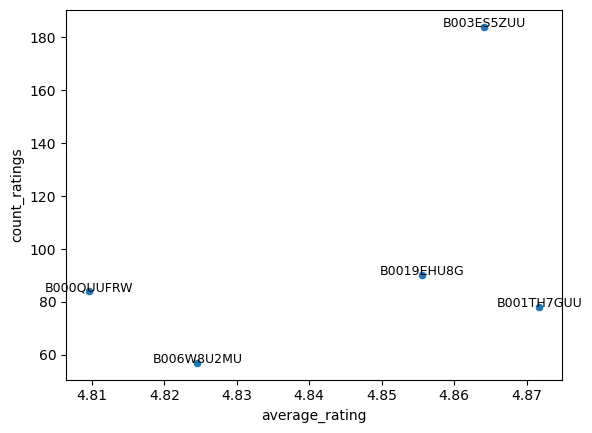

In [112]:
top_n_products_model_1(df_final, 5, 50)

Top 5 products with a minimum of 50 interactions

Top 5 items


,item_id,average_rating,count_ratings
24827,B003ES5ZUU,4.864130,184
11078,B000N99BBC,4.772455,167
38250,B007WTAJTO,4.701220,164
22460,B002V88HFE,4.698113,106
28761,B004CLYEDC,4.669492,118


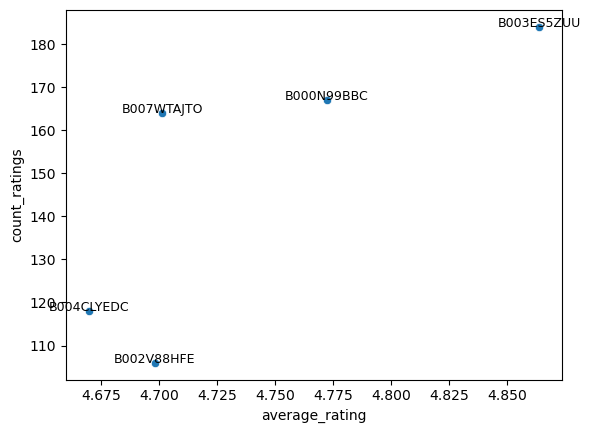

In [113]:
top_n_products_model_1(df_final, 5, 100)

# Model 2: Collaborative Filtering RS
## User-User similarity RS

Similarity model:
- use cosine similarity to find KNN similar users
- surprise library used to build remaining models

In [114]:
# import all necessary libraries

# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

In [115]:
# precision, recall, F1 functions

def precision_recall_at_k(model, k = 10, threshold = 3.5): # default set to 10 and 3.5
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)
    
    # Making predictions on the test data
    predictions = model.test(testset)
    
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    
    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)
    
    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)
    
    accuracy.rmse(predictions)
    
    print('Precision: ', precision) # Command to print the overall precision
    
    print('Recall: ', recall) # Command to print the overall recall
    
    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

Function:
- lists precision, recall @k for for desired model
- k is set to 10
- threshold is set to 3.5

In [116]:
# instantiate reader scale with expected rating scale
reader = Reader(rating_scale=(0, 5))

# load data set
data_final = Dataset.load_from_df(df_final[['user_id', 'item_id', 'rating']], reader)

# split data_final in train and test datasets
trainset, testset = train_test_split(data_final, test_size=0.2, random_state=42)

Building the model using cosine similarity

In [117]:
# similiarity options
sim_options = {
    'name': 'cosine',
    'user_based': True # if set to false this filter becomes item-item instead of user-user
}

# KNN algo to find desired similar items
sim_user_user = KNNBasic(sim_options=sim_options, verbose=False, random_state = 1)

# train algo on trrainset
sim_user_user.fit(trainset)

# compute loss functions
precision_recall_at_k(sim_user_user)

RMSE: 1.1067
Precision:  0.847
Recall:  0.718
F_1 score:  0.777


Observations:
- we set up our user-based collaborative filter using KNN
- define user-user filtering by setting 'user_based' to True
- fitted the KNN model to trainset
- - using cosine similarity (user-user)
- RMSE of 1.0012 indicates the model is very accurate at prediciting values
- Precision intuits 85.5% of all recommended items are actualy releveant
- Recall intuits 85.8% were succesfully recommended to the user
- F1 o f85.6% intuits that there is good balance between precision and recall

In [118]:
# sample user and item

df_final.user_id.sample(1, random_state=2), df_final.item_id.sample(1, random_state=2)

(7783140    A25C2M3QF9G7OQ
 Name: user_id, dtype: object,
 7783140    B00I9V8D92
 Name: item_id, dtype: object)

In [119]:
# predict the rating for a sample user
sim_user_user.predict("A3D0UM4ZD2CMAW", "B002IO2UM2", r_ui=5, verbose=True)

user: A3D0UM4ZD2CMAW item: B002IO2UM2 r_ui = 5.00   est = 4.82   {'actual_k': 16, 'was_impossible': False}


Prediction(uid='A3D0UM4ZD2CMAW', iid='B002IO2UM2', r_ui=5, est=4.815107853609571, details={'actual_k': 16, 'was_impossible': False})

Observations:
- r_ui: this is the actual rating by the user
- est: this is the estimated rating by the model
- the actual rating for this item is 5, but the model predicted 4.71
- the model under-estimated the rating

Notes
- actual_k: number os neighbors used for this prediction
- was_impossible: False means that it was possible, i.e. no cold-start issue

In [120]:
# find users who have not seen a specific item

def n_users_not_interacted_with(n, data_final, item_id):
    users_interacted_with_product = set(data_final[data_final['item_id'] == item_id]['user_id'])
    all_users = set(data_final['user_id'])
    return list(all_users.difference(users_interacted_with_product))[:n]

In [121]:
n_users_not_interacted_with(5, df_final, 'B002IO2UM2')

['A204K1OFE8OB9Y',
 'A2ZY49IDE6TY5I',
 'A1T9MILRRZ00F8',
 'A2N3JSOIQ6ZNFL',
 'AGFSSC5DBY2HU']

Observations:
- the above list of users have not seen the item passed into the function
- - User: A2Q7OJTVPIO2XH, has not seen item: B002IO2UM2

In [122]:
# predict rating for a user, who has not seen a product
sim_user_user.predict("A2Q7OJTVPIO2XH", "B002IO2UM2", verbose=True)

user: A2Q7OJTVPIO2XH item: B002IO2UM2 r_ui = None   est = 5.00   {'actual_k': 1, 'was_impossible': False}


Prediction(uid='A2Q7OJTVPIO2XH', iid='B002IO2UM2', r_ui=None, est=5, details={'actual_k': 1, 'was_impossible': False})

Observations:
- User: A2Q7OJTVPIO2XH, has not seen item: B002IO2UM2
- our estimated prediction for this item is 5
- - using 4 neighbors
- - no cold start issue

### Hyperparameters to improve the RS

KNNBasic hyperparameters:
1. k (int): number of neighbors to consider, default=40
2. min_k (int): min neighbors to consider, default=1
3. sim_options (dict): options for computing similarities
- - cosine: 
- - msd:
- - pearson:
- - pearson_baseline: 

In [123]:
# setting grid to tune hyperparameters
param_grid = {
    'k': [20, 30, 40],
    'min_k': [3, 6, 9],
    'sim_options': {
        'name': ['msd', 'cosine'],
        'user_based': [True]
    }
}

# 3-fold CV to tune hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# fit model
gs.fit(data_final)

# best rmse
print(gs.best_score['rmse'])

# combination of params to give best rmse
print(gs.best_params['rmse'])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matr

Now to build the final collaborative model using the hyperparameters received from the GS CV above

In [124]:
# useing the optimal similarity measure for user-user based collaborative filtering
sim_options = {
    'name': 'cosine',
    'user_based': True
}

# create instance of KNNBasic with optimal hyperparameters from above .best_params
sim_user_optimized = KNNBasic(
    sim_options=sim_options,
    k=40,
    min_k=6,
    random_state=1,
    verbose=False
)

# train algo on trainset
sim_user_optimized.fit(trainset)

# compute loss scores 
precision_recall_at_k(sim_user_optimized)
print("-_"*20)
precision_recall_at_k(sim_user_user)

RMSE: 1.0517
Precision:  0.836
Recall:  0.72
F_1 score:  0.774
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
RMSE: 1.1067
Precision:  0.847
Recall:  0.718
F_1 score:  0.777
RMSE: 1.1067
Precision:  0.847
Recall:  0.718
F_1 score:  0.777


Observations:
- our optimized model has improved on RMSE, Recall, and F1 score
- Precision has slightly deteriorated 

In [125]:
# use the optimized model to predice the rating for user "A3LDPF5FMB782Z" and item "1400501466"
sim_user_optimized.predict("A3LDPF5FMB782Z", "1400501466", verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 3.33   {'actual_k': 6, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=3.3333333333333335, details={'actual_k': 6, 'was_impossible': False})

Observations
- the estimated rating is 4.29 for user A3LDPF5FMB782Z on item 1400501466
- "est" is alwasy computed, even when the result is flagged, like here
- there is also a cold start problem here
- - reason being there are not enough neighbors to predict

In [126]:
def get_user_item_interaction(df, user_id, item_id):
    """
    Returns the interactions (rows) for a given user_id and item_id in the provided dataframe.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame to search.
    user_id : str
        The user ID to look for.
    item_id : str
        The item ID to look for.
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame containing the matching interactions.
    """
    return df[(df['user_id'] == user_id) & (df['item_id'] == item_id)]

In [127]:
# use the optimized model to recommend items for user "A2UOHALGF2X77Q", who has not interacted with "1400501466"
sim_user_optimized.predict("A2UOHALGF2X77Q", "1400501466", verbose=True)

user: A2UOHALGF2X77Q item: 1400501466 r_ui = None   est = 4.26   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A2UOHALGF2X77Q', iid='1400501466', r_ui=None, est=4.263416620322555, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

Observations
- same as above
- the estimate is often a global average for the item

### Finding Similar Users

In [128]:
# useing the optimal similarity measure for user-user based collaborative filtering
sim_options_msd = {
    'name': 'msd',
    'user_based': True
}

# create instance of KNNBasic with optimal hyperparameters from above .best_params
sim_user_optimized_msd = KNNBasic(
    sim_options=sim_options_msd,
    k=40,
    min_k=6,
    random_state=1,
    verbose=False
)

# train algo on trainset
sim_user_optimized_msd.fit(trainset)

# compute loss scores 
precision_recall_at_k(sim_user_optimized_msd)
print("-_"*20)
precision_recall_at_k(sim_user_optimized)

RMSE: 1.0516
Precision:  0.836
Recall:  0.721
F_1 score:  0.774
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
RMSE: 1.0517
Precision:  0.836
Recall:  0.72
F_1 score:  0.774
RMSE: 1.0517
Precision:  0.836
Recall:  0.72
F_1 score:  0.774


In [129]:
# use optimized model (cosine) to find the 5 nearest neighbors for the first user in the list
sim_user_optimized.get_neighbors(0, 5) 

[3, 4, 5, 6, 8]

In [130]:
# use optimized_msd model (updated to use mean squared distance) to find the 5 nearest neighbors for the first user in the list
sim_user_optimized_msd.get_neighbors(0, 5)

[5, 8, 19, 22, 25]

Observations
- there is a difference in nearest neighbors when usiong cosine or msd
- cosine finds the angle between users/items (as a vector)
- msd finds the average squared difference between users/items

### Implementing the recommendation algorith, based on the optimized KNNBasic model

In [131]:
def get_recommendations(data, user_id, top_n, algo):
    
    # Creating an empty list to store the recommended product ids
    recommendations = []
    
    # Creating an user item interactions matrix 
    user_item_interactions_matrix = df_final.pivot(index = 'user_id', columns = 'item_id', values = 'rating')
    
    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:
        
        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est
        
        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

In [132]:
# use similarity-based recommendation 
recommendations = get_recommendations(df_final, "A3LDPF5FMB782Z", 5, sim_user_optimized_msd)

In [133]:
# dataframe for the above recommendations
pd.DataFrame(recommendations, columns = ['item_id', 'predicted_rating'])

,item_id,predicted_rating
0,B00006RVPW,5
1,B0007QKMQY,5
2,B001TH7GUU,5
3,B002JQNXZC,5
4,B0035FZJHQ,5


### Item-Item Similarity filtering

In [134]:
# similarity options
sim_options_items ={
    'name': 'cosine',
    'user_based': False # earlier we declared this as True
}

# KNN algo to find similar items
sim_item_item = KNNBasic(sim_options=sim_options_items, random_state=1, verbose=False)

# train the algo on trainset
sim_item_item.fit(trainset)

# compute loss metrics
precision_recall_at_k(sim_item_item)

RMSE: 1.0995
Precision:  0.824
Recall:  0.704
F_1 score:  0.759


Observations
- the model is performing well but has small room for improvement

In [135]:
# predict rating for a sample user with an interacted product
sim_item_item.predict("A3LDPF5FMB782Z", "1400501466", verbose=False)

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=4.25, details={'actual_k': 40, 'was_impossible': False})

Observations
- estimated rating for this user-item paairing is 4.27
- this estimated rating is off 22 neighbbors (similar items)

In [136]:
# predict rating for a sample user with an interacted product
sim_item_item.predict("A2UOHALGF2X77Q", "1400501466", verbose=True)

user: A2UOHALGF2X77Q item: 1400501466 r_ui = None   est = 4.50   {'actual_k': 4, 'was_impossible': False}


Prediction(uid='A2UOHALGF2X77Q', iid='1400501466', r_ui=None, est=4.5, details={'actual_k': 4, 'was_impossible': False})

Observations:
- estiamted rating for this user-item is 4.00
- there was only 1 neighbor used in this item-item filter

### Hyperparameter tuning

In [ ]:
# setting grid to tune hyperparameters (use False for item-item)
param_grid = {
    'k': [15, 20, 25, 30,35],
    'min_k': [3, 4, 5, 6],
    'sim_options': {
        'name': ['msd', 'cosine'],
        'user_based': [False] # False for item-item filtering
    }
}

# 3-fold CV to tune hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# fit model
gs.fit(data_final)

# best rmse
print(gs.best_score['rmse'])

# combination of params to give best rmse
print(gs.best_params['rmse'])

Computing the msd similarity matrix...
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...


Observations
- We found the optimal hyperparameters here
- optimal k = 20
- optimal min_k = 6

### Build final model

In [ ]:
# # similarity options
sim_options_items ={
    'name': 'cosine',
    'user_based': False # earlier we declared this as True
}

# KNN algo to find similar items
sim_item_item_optimized = KNNBasic(
    sim_options=sim_options_items,
    k=20,
    min_k=6,
    random_state=1,
    verbose=False
)

# train the algo on trainset
sim_item_item_optimized.fit(trainset)

# compute loss metrics
precision_recall_at_k(sim_item_item_optimized)
print("-_"*10)
precision_recall_at_k(sim_item_item)

RMSE: 0.9626
Precision:  0.834
Recall:  0.877
F_1 score:  0.855
-_-_-_-_-_-_-_-_-_-_
RMSE: 0.9950
Precision:  0.838
Recall:  0.845
F_1 score:  0.841


Observations
- RMSE is better in the optimized model
- Recall and F1 are improved (higher)
- Precision is lower
- Recall and F1 outweigh the precision deterioration

In [ ]:
# use the optimized model to recommend for user and item
sim_item_item_optimized.predict("A3LDPF5FMB782Z", "1400501466", verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 4.25   {'actual_k': 20, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=4.25, details={'actual_k': 20, 'was_impossible': False})

Observations:
- for this user-item pairing the sestimated rating is 4.25
- the number of neighbors used was 20

In [ ]:
# use the optimized model to recommend for user and item
sim_item_item_optimized.predict("A2UOHALGF2X77Q", "1400501466", verbose=True)

user: A2UOHALGF2X77Q item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A2UOHALGF2X77Q', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

Observations
- estimated value for this user-item pairing is 4.29
- even though there are not enough neighbors to confidently predict 
- there is a cold start problem here
- this is a typical problem in collaborative filtering

### Identofy similar items to a given item

In [ ]:
sim_item_item_optimized.get_neighbors(0, 5)

[3, 11, 29, 40, 48]

In [ ]:
# predict top 5 items for user
recommendations = get_recommendations(df_final, "A1A5KUIIIHFF4U", 5, sim_item_item_optimized)

# build a dataframe of these recommendations
pd.DataFrame(recommendations, columns=['item_id', 'predicted_rating'])

,item_id,predicted_rating
0,1400532655,4.292024
1,1400599997,4.292024
2,9983891212,4.292024
3,B00000DM9W,4.292024
4,B00000J1V5,4.292024


Observations
- using the optimized item-item filter, the top 5 recommended items for the user all have the highest possible predicted rating (5.0)
- this suggests the model is confident in its recommendations for this user
- however, the lack of rating diversity may indicate that the model is overestimating or that the user profile is very similar to others who rated these items highly
- further analysis may be needed to ensure the recommendations are truly personalized and not just reflecting global popularity or rating bias

# Model 3: Matrix Factorization

Personalised recommendation systems use latent features, which are all still based on past behaviour

SVD

In [ ]:
# svd matrix factorization
svd = SVD(random_state=1)

# train algo on trainset
svd.fit(trainset)

# compute loss
precision_recall_at_k(svd)
print("-_"*10)
precision_recall_at_k(sim_item_item_optimized)
print("-_"*10)
precision_recall_at_k(sim_item_item)

RMSE: 0.8882
Precision:  0.853
Recall:  0.88
F_1 score:  0.866
-_-_-_-_-_-_-_-_-_-_
RMSE: 0.9626
Precision:  0.834
Recall:  0.877
F_1 score:  0.855
-_-_-_-_-_-_-_-_-_-_
RMSE: 0.9950
Precision:  0.838
Recall:  0.845
F_1 score:  0.841


Observations
- SVD is the best baseline model so far
- RMSE is lower the our previous best model, the optimized item-item model
- RMSE is lower than the previous best but Precision, Recall, and F1 are all improved

In [ ]:
# making predictions for this user-item pair, who have previously interacted
svd.predict("A3LDPF5FMB782Z", "1400501466", r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.08   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.081406749810685, details={'was_impossible': False})

Observations
- the svd model estimates 4.08, when the true rating is 5
- the model is under-estimating
- no cold-start problem

In [ ]:
# make predictions for this user-item pair, who have not interacted
svd.predict("A2UOHALGF2X77Q", "1400501466", verbose = True)

user: A2UOHALGF2X77Q item: 1400501466 r_ui = None   est = 4.16   {'was_impossible': False}


Prediction(uid='A2UOHALGF2X77Q', iid='1400501466', r_ui=None, est=4.156510633154892, details={'was_impossible': False})

Observations
- the estimated rating for this item is 4.16
- the user has not interacted with this item
- there was no cold-start problem

### Hyperparameter training for Matrix Factorisation RS (using SGD)

- n_epochs: num of iterations for SGD algo (Stochastic Gradient Descent)
- lr_all: learning rate
- reg_all: regularization term

In [ ]:
# params to tune model
param_grid = {
    'n_epochs': [14, 15, 16, 17, 18, 19],
    'lr_all': [0.0065, 0.008, 0.0095, 0.011, 0.0125, 0.014, 0.0155],
    'reg_all': [0.015, 0.017, 0.02, 0.022, 0.025],
    'n_factors': [50, 100, 150, 200]
}

# 3-fold DS CV (singular value decomposition)
gs = GridSearchCV(
    SVD,
    param_grid,
    measures=['rmse'],
    cv=3,
    n_jobs=-1
)

# fit the data
gs.fit(data_final) # make sure to use surprise datset, not pandas df

# best RMSE
print(gs.best_score['rmse'])

# combo params to give best RMSE
print(gs.best_params['rmse'])


0.9028807804807601
{'n_epochs': 16, 'lr_all': 0.0065, 'reg_all': 0.022, 'n_factors': 50}


Build the SVD model using the hyperparameters

In [ ]:
# build optimized SVD model using best params from grid search
best_params = gs.best_params['rmse']

# builds SVD optimized model by directly passing hyperparameters 
svd_optimized = SVD(
    n_epochs=best_params['n_epochs'],
    lr_all=best_params['lr_all'],
    reg_all=best_params['reg_all'],
    n_factors=best_params['n_factors'],
    random_state=1
)

# train algo on trainset
svd_optimized.fit(trainset)

# compute loss
precision_recall_at_k(svd_optimized)
print("-_"*20)
precision_recall_at_k(svd)

RMSE: 0.8870
Precision:  0.853
Recall:  0.877
F_1 score:  0.865
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
RMSE: 0.8882
Precision:  0.853
Recall:  0.88
F_1 score:  0.866


Observations
- SVD optimized is performing slightly below the base model

## Tune the SVD_pp model using the hyperparameters

In [ ]:
from surprise import SVDpp

# build SVDpp model

# svd matrix factorization
svd_pp = SVDpp(random_state=1)

# train algo on trainset
svd_pp.fit(trainset)


In [ ]:
# params to tune model
param_grid = {
    'n_epochs': [14, 15, 16, 17, 18, 19],
    'lr_all': [0.0065, 0.008, 0.0095, 0.011, 0.0125, 0.014, 0.0155],
    'reg_all': [0.015, 0.017, 0.02, 0.022, 0.025],
    'n_factors': [50, 100, 150, 200]
}

# 3-fold DS CV (singular value decomposition)
gs = GridSearchCV(
    SVDpp,
    param_grid,
    measures=['rmse'],
    cv=3,
    n_jobs=-1
)

# fit the data
gs.fit(data_final) # make sure to use surprise datset, not pandas df

# best RMSE
print(gs.best_score['rmse'])

# combo params to give best RMSE
print(gs.best_params['rmse'])


0.9066371516655729
{'n_epochs': 14, 'lr_all': 0.008, 'reg_all': 0.022, 'n_factors': 50}


In [ ]:
# builds SVD optimized model by directly passing hyperparameters 
svd_pp_optimized = SVDpp(
    n_epochs=14,
    lr_all=0.008,
    reg_all=0.022,
    n_factors=50,
    random_state=1
)

# train algo on trainset
svd_pp_optimized.fit(trainset);

Observations
- added an SVD 

In [ ]:

# compute loss
precision_recall_at_k(svd_pp_optimized)
print("-_"*10)
precision_recall_at_k(svd_pp)
print("-_"*10)
precision_recall_at_k(svd)
print("-_"*10)
precision_recall_at_k(sim_item_item_optimized)
print("-_"*10)
precision_recall_at_k(sim_item_item)

RMSE: 0.8901
Precision:  0.854
Recall:  0.876
F_1 score:  0.865
-_-_-_-_-_-_-_-_-_-_
RMSE: 0.8875
Precision:  0.853
Recall:  0.868
F_1 score:  0.86
-_-_-_-_-_-_-_-_-_-_
RMSE: 0.8882
Precision:  0.853
Recall:  0.88
F_1 score:  0.866
-_-_-_-_-_-_-_-_-_-_
RMSE: 0.9626
Precision:  0.834
Recall:  0.877
F_1 score:  0.855
-_-_-_-_-_-_-_-_-_-_
RMSE: 0.9950
Precision:  0.838
Recall:  0.845
F_1 score:  0.841


Observations
- tried the "Netflix Model", SVD++ but this model thrives with richer datasets
- - such as likes, clicks, views in addition to ratings
- the model with the best RMSE score is 'sim_item_item'
